In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

from sklearn import tree
import xgboost as xgb

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV


from sklearn.model_selection import train_test_split

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
import xgboost as xgb
import pandas as pd
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
boston = load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = pd.Series(boston.target)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [4]:
regressor = xgb.XGBRegressor(
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=3,
    eta = 0.001
)

In [5]:
regressor.fit(X_train, y_train)

[14:30:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(eta=0.001)

# Data Processing Pipeline

In [6]:
df = pd.read_excel('~/Desktop/USF_courses/Practicum/data/BrainMets_List_July2020_LF_OS.xlsx')

#### Get patient number
def get_patient(col):
    lst = col.split('-')
    return lst[2]

#### Response_v: use time to death if it is not null else positive follow-up time
def get_response(df):
    if df['Time to death']>0:
        return df['Time to death']
    elif df['Follow-up time']>0:
        return df['Follow-up time']
       
df['patient'] = df['PiCare MetID'].apply(lambda x:get_patient(x))
df['response_v'] = df.apply(lambda x:get_response(x),axis=1)

#### Convert all 1/0 to True/False
def binary(col):
    if col == '1' or col == 1:
        return 'True'
    if col == '0' or col == 0:
        return 'False'
    return col
df['ECM'] = df['ECM'].apply(lambda x:binary(x))
df['Prior_Chemo']=df['Prior_Chemo'].apply(lambda x:binary(x))
df['Prior_Chemo'].unique()

array(['True', 'False', 'Unkn'], dtype=object)

In [7]:
#Drop columns that are all null value
def drop_column(data, col):
    return data.drop(columns=[col])

for col in df.columns:
    if df[col].isnull().sum()==10445:
        print('drop empty column:',col)
        df = drop_column(df,col)
df.shape

drop empty column: Race
drop empty column: GPA
drop empty column: RPA
drop empty column: ECOG
drop empty column: Conformity index
drop empty column: Gradient index
drop empty column: Heterogeneity index
drop empty column: Distance from Ventricle
drop empty column: BRAF_status
drop empty column: CKIT_status
drop empty column: NRAS_status
drop empty column: EFGR_status
drop empty column: ALK_status
drop empty column: HER2-amplified status
drop empty column: Distance_from_ventricle


(10445, 43)

In [8]:
def hash_encode_cols(data, col):
    print("Encoding column ",col)
    data[col] = data[col].apply(hash).astype("int32")
    
def label_encoding_with_NAs(data,col):
    data[col] = data[col].astype('category').cat.as_ordered()
    encoder = data[col].cat.categories
    #print("Encoding column ",col)
    # leaving 0 for NAs
    data[col] = data[col].cat.codes + 1

In [9]:
#### Only keep first GK data for one patient
df_keepfirst = df.sort_values(by = 'Date GK').drop_duplicates(subset = ['patient'],keep = 'first')

In [10]:
df_tree= drop_column(df_keepfirst,'Time to death')

In [11]:
df_tree.columns

Index(['PiCare MetID', 'Failure-binary', 'Failure-eventFreeTime',
       'Follow-up time', 'Date GK', 'Age', 'Sex', 'Primary tumor Site',
       'Primary tumor Histology', 'ECM', 'Location', 'Brief location', 'Side',
       'Lateral dimension', 'AP dimension', 'Vertical dimension',
       '#Metastases at 1st GK', 'Time between prim and met diagnosis',
       'Prior SRS to same lesion', 'Prior SRS to other lesion',
       'KPS at 1st GK', 'Prescribed IDL', 'Target vol in IDL', 'IDL volume',
       'Vol in 12 Gy line', 'Vol in 10 Gy line', 'Prior_EBRT', 'Prior_RS',
       'Prior_Chemo', 'Conc_Chemo', 'Salvage_RS', 'Salv_surg', 'Headaches',
       'Seizures', 'Neuro symptoms', 'Prescription Dose', 'Max Dose',
       'Target volume', 'Target vol in IDL.1', 'Maximum Tumor Diameter',
       'patient', 'response_v'],
      dtype='object')

In [12]:
columns_drop = """'PiCare MetID'
'Failure-binary'
'Failure-eventFreeTime'
'Follow-up time'
'Date GK'
'Lateral dimension'
'AP dimension'
'Vertical dimension'
'Prescribed IDL'
'Target vol in IDL'
'IDL volume'
'Vol in 12 Gy line'
'Vol in 10 Gy line'
'Salvage_RS'
'Salv_surg'
'Headaches'
'Seizures'
'Prescription Dose'
'Max Dose'
'Target vol in IDL.1'
'patient'"""

In [13]:
## Drop columns according to the excel spreadsheet
col_lst = columns_drop.split('\n')
print(len(col_lst))
for col in col_lst:
    col=col.strip("'")
    print('drop column:',col)
    df_tree= drop_column(df_tree,col)

21
drop column: PiCare MetID
drop column: Failure-binary
drop column: Failure-eventFreeTime
drop column: Follow-up time
drop column: Date GK
drop column: Lateral dimension
drop column: AP dimension
drop column: Vertical dimension
drop column: Prescribed IDL
drop column: Target vol in IDL
drop column: IDL volume
drop column: Vol in 12 Gy line
drop column: Vol in 10 Gy line
drop column: Salvage_RS
drop column: Salv_surg
drop column: Headaches
drop column: Seizures
drop column: Prescription Dose
drop column: Max Dose
drop column: Target vol in IDL.1
drop column: patient


In [14]:
df_tree.columns

Index(['Age', 'Sex', 'Primary tumor Site', 'Primary tumor Histology', 'ECM',
       'Location', 'Brief location', 'Side', '#Metastases at 1st GK',
       'Time between prim and met diagnosis', 'Prior SRS to same lesion',
       'Prior SRS to other lesion', 'KPS at 1st GK', 'Prior_EBRT', 'Prior_RS',
       'Prior_Chemo', 'Conc_Chemo', 'Neuro symptoms', 'Target volume',
       'Maximum Tumor Diameter', 'response_v'],
      dtype='object')

In [15]:
df_tree = df_tree.dropna(subset = ['response_v','Primary tumor Site','#Metastases at 1st GK'])

In [16]:
df_drop = df_tree[df_tree.columns[~df_tree.isnull().any()]]

In [17]:
df_drop.shape

(1577, 10)

In [18]:
df_drop['Primary tumor Site'].unique()

array(['Breast', 'Melanoma', 'GI', 'Lung', 'Kidney', 'Unknown', 'Other',
       'GYN', 'Sarcoma'], dtype=object)

In [19]:
##create different datasets separated by primary tumor site
dfs = []
for site in df_tree['Primary tumor Site'].unique():
    dff= df_tree[df_tree['Primary tumor Site']==site]
    if (site != 'Unknown') & (site != 'Other'):
        dfs.append((site,dff))

In [20]:
for site, dff in dfs:
    print (site, dff.shape)

Breast (371, 21)
Melanoma (345, 21)
GI (58, 21)
Lung (579, 21)
Kidney (96, 21)
GYN (39, 21)
Sarcoma (22, 21)


In [21]:
def split_target(df, target):
    Y = df[target].values
    X = df.drop(columns=[target])
    return X, Y

def process(df):
    #only keep columns with less than 50 null data
    na_number = df.isnull().sum()
    df = df[df.columns[na_number<50]].dropna()
    df = drop_column(df,'Primary tumor Site')
    #encoding catagorical columns and NA data
    for c,dtype in zip(df.columns,df.dtypes):
        if dtype == 'object' or dtype == 'datetime64[ns]':
            label_encoding_with_NAs(df,c)
    X,y = split_target(df,'response_v')
    return X,y
# X,y = process(dfs[0][1])

In [22]:
def feature_importance_visual(ax,col,fi,t = 'Feature Importance Visualization'):

    ax.bar(col,fi)
#    ax.xticks(fontsize=12)

    ax.set_title(label = t,
                 pad=10,
                size = 20)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)

# XGBoost

In [23]:
# Random search parameters
def random_grid_xgb(n):
    "Random hyperparameters for xgboost"
    max_depth = [int(x) for x in np.linspace(5, 20, num = n)]
    max_features = [x for x in np.linspace(0.1, 0.8, num = n)]
    min_samples_leaf = [int(x) for x in np.linspace(5, 20, num = n)]
    alpha = [x for x in np.linspace(0, 1, num = n)]
    eta = [x for x in np.linspace(0, 1, num = n)]
    gamma = [x for x in np.linspace(0, 15, num = n)]
    min_child_weight = [x for x in np.linspace(0, 15, num = n)]
    

    random_grid = {'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_leaf': min_samples_leaf,
                   'alpha':alpha,
                   'eta':eta,
                   'gamma':gamma,
                   'min_child_weight':min_child_weight}
    return random_grid

def importance_rank(model,col):
    'sorted feature importance dictionary'
    imp = model.feature_importances_
    imp_dic = {}
    for i,col in enumerate(X.columns):
        imp_dic[col]=imp[i]
    ranked_fea = dict(sorted(imp_dic.items(),key = lambda x:x[1],reverse=True))
    return ranked_fea

def Random_search_cv(model,X,y,niter = 20,num = 15):
    #Cross-validation for hyperparameter search
    "model = xgb.XGBRegressor OR xgb.XGBClassifier"


    m = model(n_estimators=100)

    m_random = RandomizedSearchCV(estimator = m, 
                                   param_distributions = random_grid_xgb(num),
                                   n_iter = 10, 
                                   random_state=42, 
                                   verbose=0, 
                                   n_jobs = -1)

    m_random.fit(X,y)

    best_score = m_random.best_score_
    
    #Get the 'best' hyperparameter and fit all the data
    h1 = m_random.best_params_['min_samples_leaf']
    h2 = m_random.best_params_['max_features']
    h3 = m_random.best_params_['max_depth']
    h4 = m_random.best_params_['gamma']
    h5 = m_random.best_params_['eta']
    h6 = m_random.best_params_['alpha']
    h7 = m_random.best_params_['min_child_weight']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    #model with all features
    m_all = model(n_jobs = -1, 
                   n_estimators=100, 
                   min_samples_leaf=h1,
                   max_features=h2, 
                   max_depth=h3, 
                   gamma = h4,
                   eta = h5,
                   alpha = h6,
                   min_child_weight = h7,
                   verbose=0)

    m_all.fit(X_train,y_train)
    
    #model with only top 5 features
    features = importance_rank(m_all,X.columns)
    keys = list(features.keys())[:5]
    
    m_top5 = model(n_jobs = -1, 
                   n_estimators=100, 
                   min_samples_leaf=h1,
                   max_features=h2, 
                   max_depth=h3, 
                   gamma = h4,
                   eta = h5,
                   alpha = h6,
                   min_child_weight = h7,
                   verbose=0)
    m_top5.fit(X_train[keys],y_train)
    
    if model == xgb.XGBRegressor:    
    # compute mse & r2 for test set
        y_all_pred = m_all.predict(X_test)
        mse_all = mean_squared_error(y_test,y_all_pred)
        r2_all =r2_score(y_test,y_all_pred)

        y_top5_pred = m_top5.predict(X_test[keys])
        mse_top5 = mean_squared_error(y_test,y_top5_pred)
        r2_top5 =r2_score(y_test,y_top5_pred)
        
        all_matrix = mse_all,r2_all
        top5_matrix = mse_top5,r2_top5
    
    if model == xgb.XGBClassifier:
        y_all_pred = m_all.predict(X_test)
        accuracy_all = accuracy_score(y_test,y_all_pred)
        roc_all = roc_auc_score(y_test,m_all.predict_proba(X_test)[:, 1])

        y_top5_pred = m_top5.predict(X_test[keys])
        accuracy_top5 = accuracy_score(y_test,y_top5_pred)
        roc_top5 =roc_auc_score(y_test,m_top5.predict_proba(X_test[keys])[:, 1])        
        
        all_matrix = accuracy_all,roc_all
        top5_matrix = accuracy_top5,roc_top5
        

    return m_random,(m_all, all_matrix),(m_top5,top5_matrix),X.shape,features


## Regression

In [24]:
#training
info = []
for site, data in dfs:
    print(site)
    X,y = process(data)
    if X.shape[0]<20:
        continue
    output = Random_search_cv(xgb.XGBRegressor,X,y,niter = 20,num = 15)

    info.append((site,output))

Breast
[14:31:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Melanoma
[14:31:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
GI
Lung
[14:31:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:31:06] WARNING: src/objective/regression_obj

#### Breast:
X_shape: 	 (307, 17)
           Model         mse     r2  \
0    all feature  380737.842 -0.251   
1  top5 features  585357.410 -0.923   

                                          parameters  
0  {'min_samples_leaf': 7, 'min_child_weight': 15...  
1  {'min_samples_leaf': 7, 'min_child_weight': 15...  



#### Melanoma:
X_shape: 	 (309, 16)
           Model         mse     r2  \
0    all feature  646153.461 -0.237   
1  top5 features  577576.216 -0.106   

                                          parameters  
0  {'min_samples_leaf': 16, 'min_child_weight': 7...  
1  {'min_samples_leaf': 16, 'min_child_weight': 7...  



#### Lung:
X_shape: 	 (502, 15)
           Model         mse     r2  \
0    all feature  736646.178 -0.220   
1  top5 features  797401.025 -0.321   

                                          parameters  
0  {'min_samples_leaf': 6, 'min_child_weight': 9....  
1  {'min_samples_leaf': 6, 'min_child_weight': 9....  



#### Kidney:
X_shape: 	 (74, 17)
       

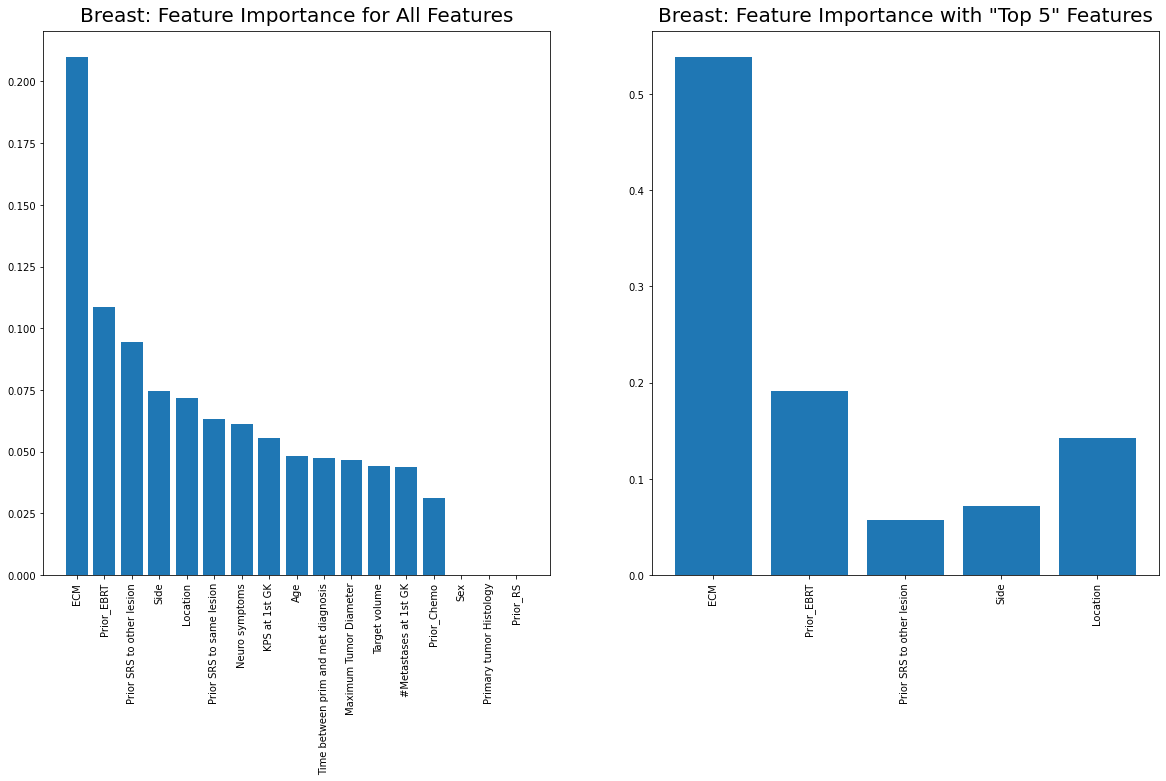

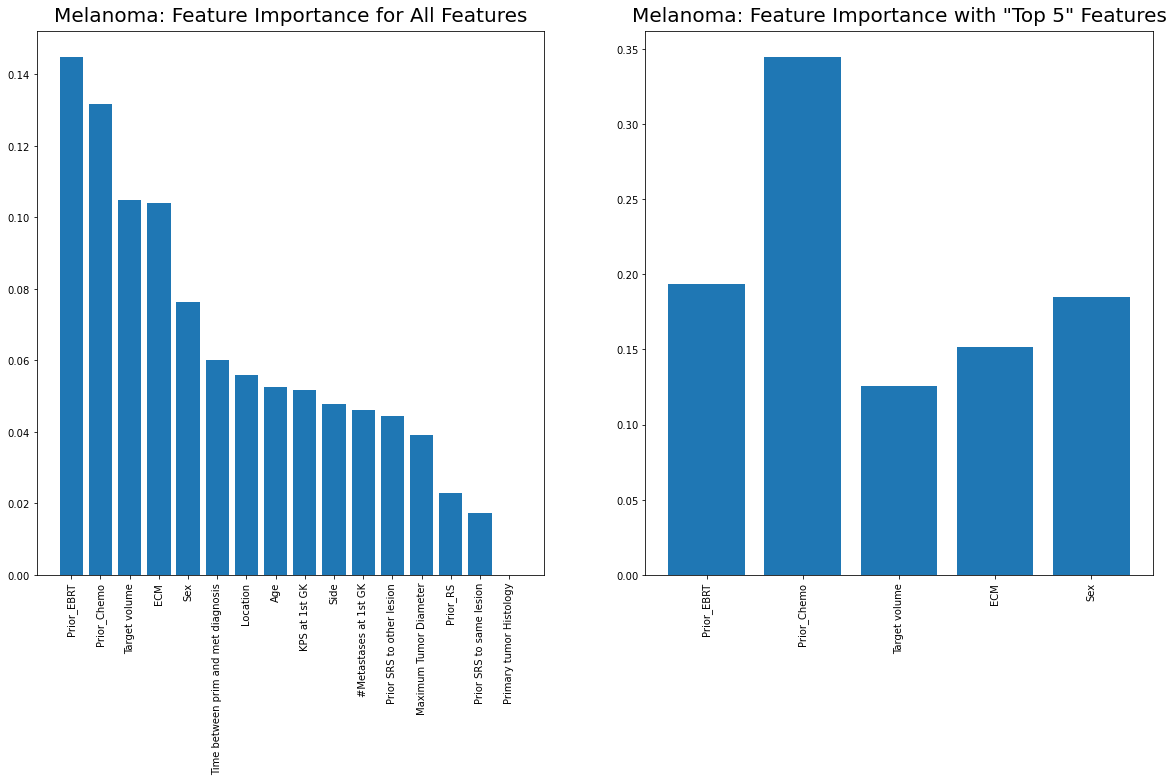

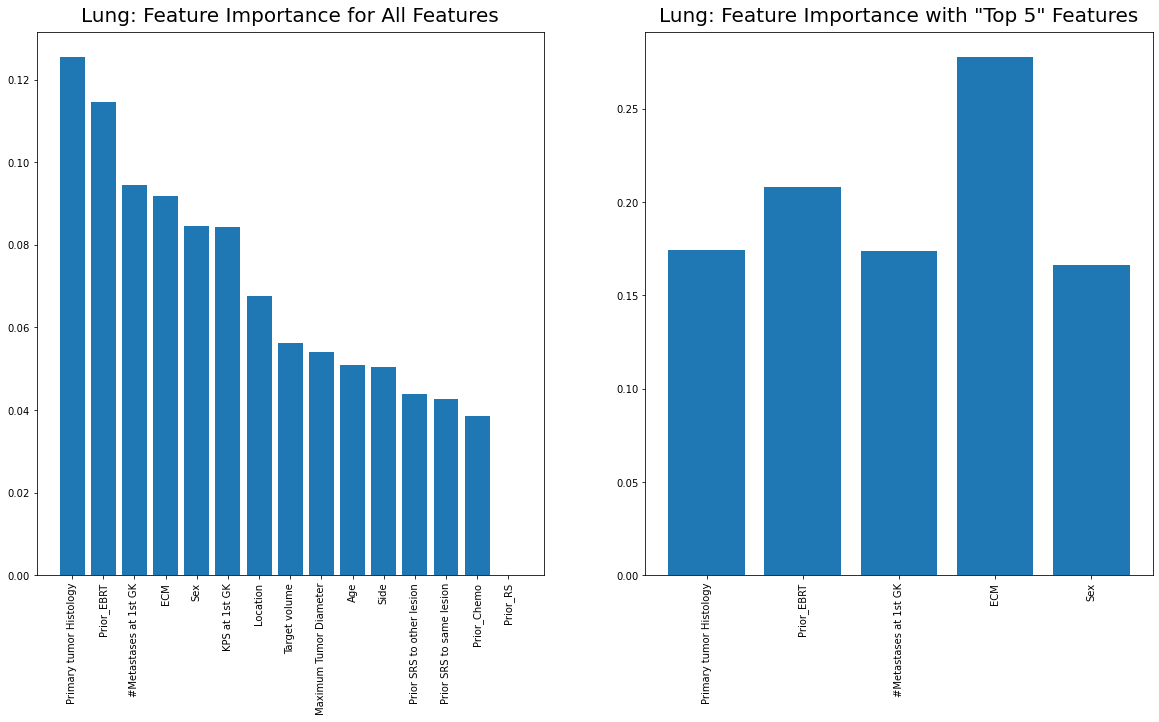

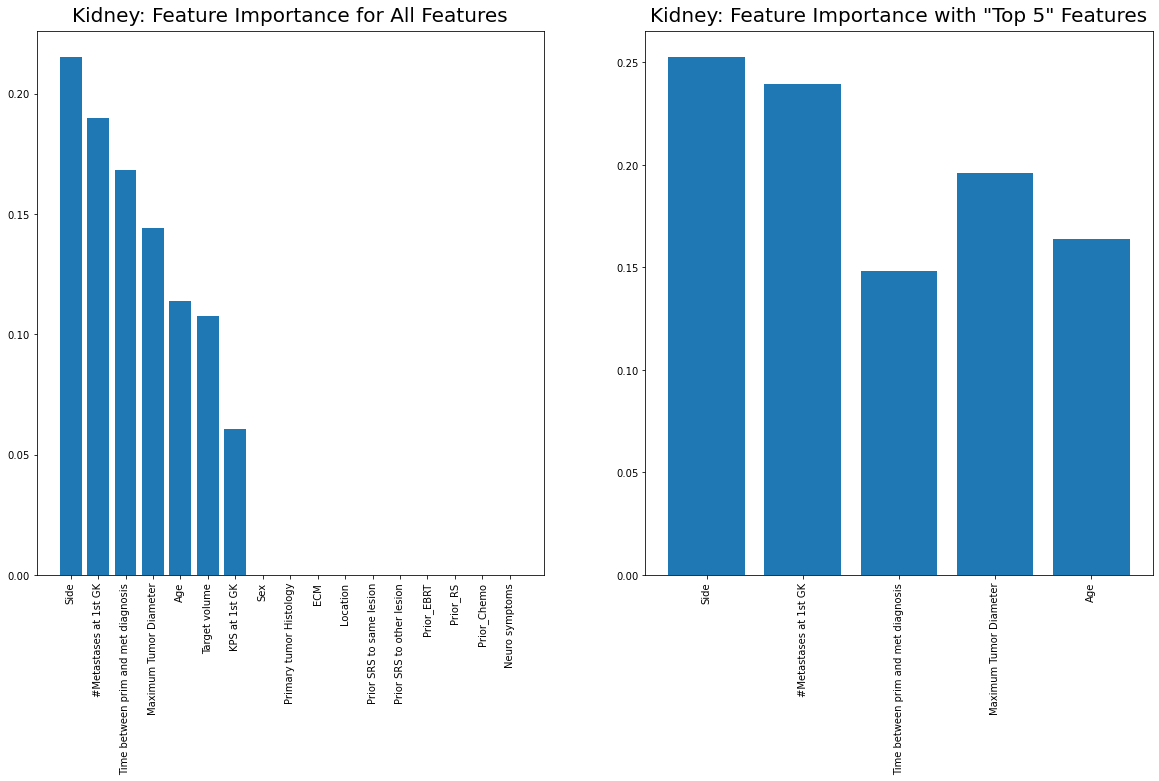

In [25]:
for site,output in info:
    m_random,(m_all, (mse_all, r2_all)),(m_top5,(mse_top5,r2_top5)),shape,features = output
    
    print('####',site+':')
    print('X_shape: \t',shape)
    
    data = [['all feature',mse_all,r2_all,m_random.best_params_],
            ['top5 features',mse_top5,r2_top5,m_random.best_params_]]
    result = pd.DataFrame(data,columns = ['Model','mse','r2','parameters'])
    result['mse'] = result['mse'].apply(lambda x: np.round(x,3))
    result['r2'] = result['r2'].apply(lambda x: np.round(x,3))
    
    print(result)
    print('\n\n')

    fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (20,10))

    feature_importance_visual(ax1,features.keys(),features.values(),
                              f'{site}: Feature Importance for All Features')
    feature_importance_visual(ax2,list(features.keys())[:5],m_top5.feature_importances_,
                              f'{site}: Feature Importance with "Top 5" Features')


## Classifier

In [26]:
#training
info = []
for site, data in dfs:
    print(site)
    X,y = process(data)
    if X.shape[0]<20:
        continue
    y1 = [1 if t>=365 else 0 for t in y]
    y2 = [1 if t>=365*2 else 0 for t in y]
    output1 = Random_search_cv(xgb.XGBClassifier,X,y1,niter = 20,num = 15)
    output2 = Random_search_cv(xgb.XGBClassifier,X,y2,niter = 20,num = 15)
    info.append((site,output1,output2))

Breast
Melanoma


/Users/Young/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()


GI
Lung


/Users/Young/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/Users/Young/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()


Kidney
GYN
Sarcoma


/Users/Young/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()


#### Breast:
X_shape: 	 (307, 17)
                  Model  accuracy  roc_auc  \
0    1-year all feature   0.50649  0.56606   
1  1-year top5 features   0.55844  0.57182   
2    2-year all feature   0.68831  0.58465   
3  2-year top5 features   0.67532  0.54254   

                                          parameters  
0  {'min_samples_leaf': 16, 'min_child_weight': 7...  
1  {'min_samples_leaf': 16, 'min_child_weight': 7...  
2  {'min_samples_leaf': 6, 'min_child_weight': 13...  
3  {'min_samples_leaf': 6, 'min_child_weight': 13...  



#### Melanoma:
X_shape: 	 (309, 16)
                  Model  accuracy  roc_auc  \
0    1-year all feature   0.69231  0.66512   
1  1-year top5 features   0.69231  0.66782   
2    2-year all feature   0.88462  0.50000   
3  2-year top5 features   0.88462  0.50000   

                                          parameters  
0  {'min_samples_leaf': 10, 'min_child_weight': 6...  
1  {'min_samples_leaf': 10, 'min_child_weight': 6...  
2  {'min_samples_leaf': 6

/Users/Young/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()
/Users/Young/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()


#### Lung:
X_shape: 	 (502, 15)
                  Model  accuracy  roc_auc  \
0    1-year all feature   0.65873  0.75446   
1  1-year top5 features   0.69048  0.75924   
2    2-year all feature   0.74603  0.50000   
3  2-year top5 features   0.74603  0.50000   

                                          parameters  
0  {'min_samples_leaf': 7, 'min_child_weight': 15...  
1  {'min_samples_leaf': 7, 'min_child_weight': 15...  
2  {'min_samples_leaf': 6, 'min_child_weight': 9....  
3  {'min_samples_leaf': 6, 'min_child_weight': 9....  



#### Kidney:
X_shape: 	 (74, 17)
                  Model  accuracy  roc_auc  \
0    1-year all feature   0.57895      0.5   
1  1-year top5 features   0.57895      0.5   
2    2-year all feature   0.84211      0.5   
3  2-year top5 features   0.84211      0.5   

                                          parameters  
0  {'min_samples_leaf': 6, 'min_child_weight': 9....  
1  {'min_samples_leaf': 6, 'min_child_weight': 9....  
2  {'min_samples_leaf': 6, 'mi

/Users/Young/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:546: RuntimeWarning: invalid value encountered in true_divide
  return all_features / all_features.sum()


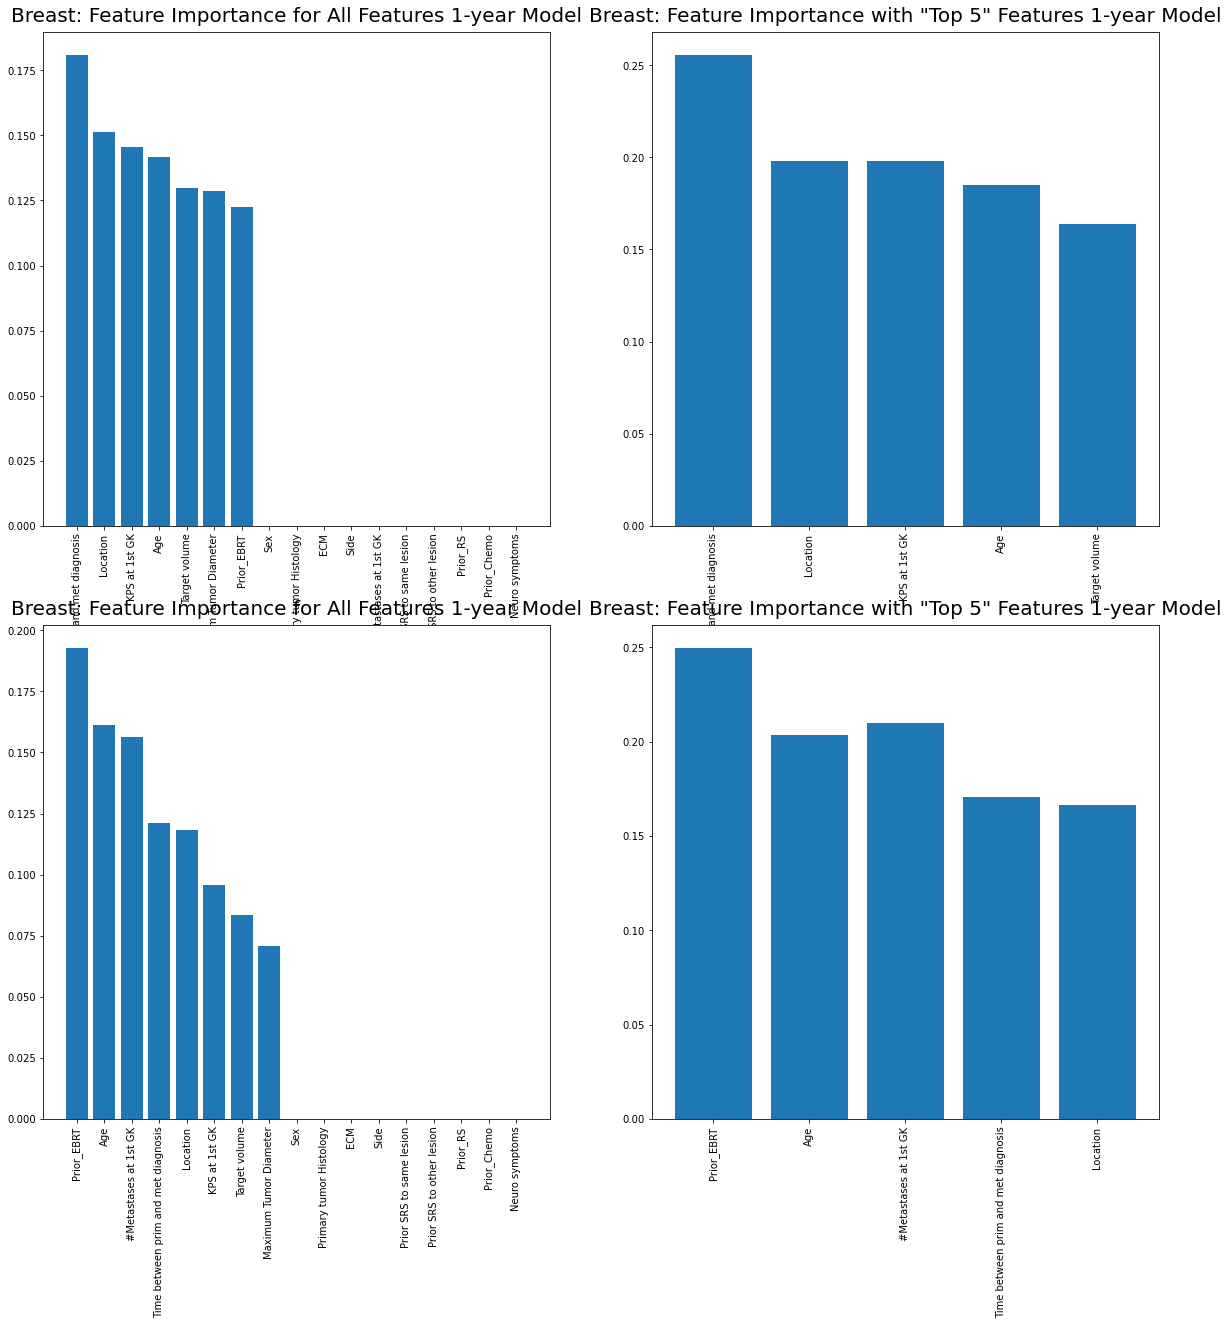

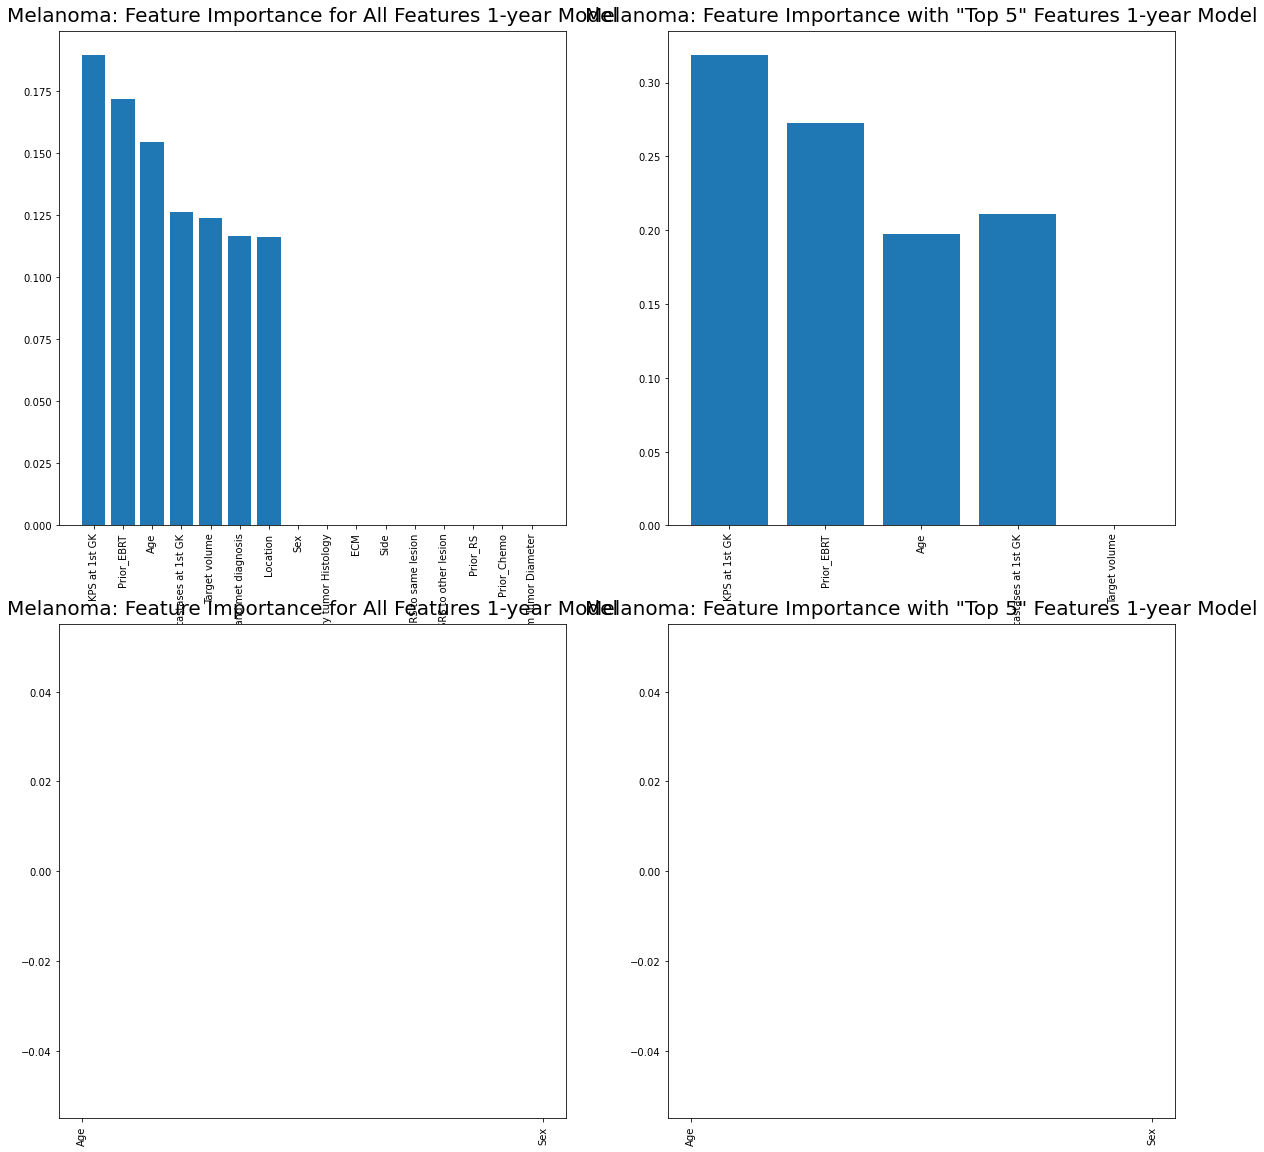

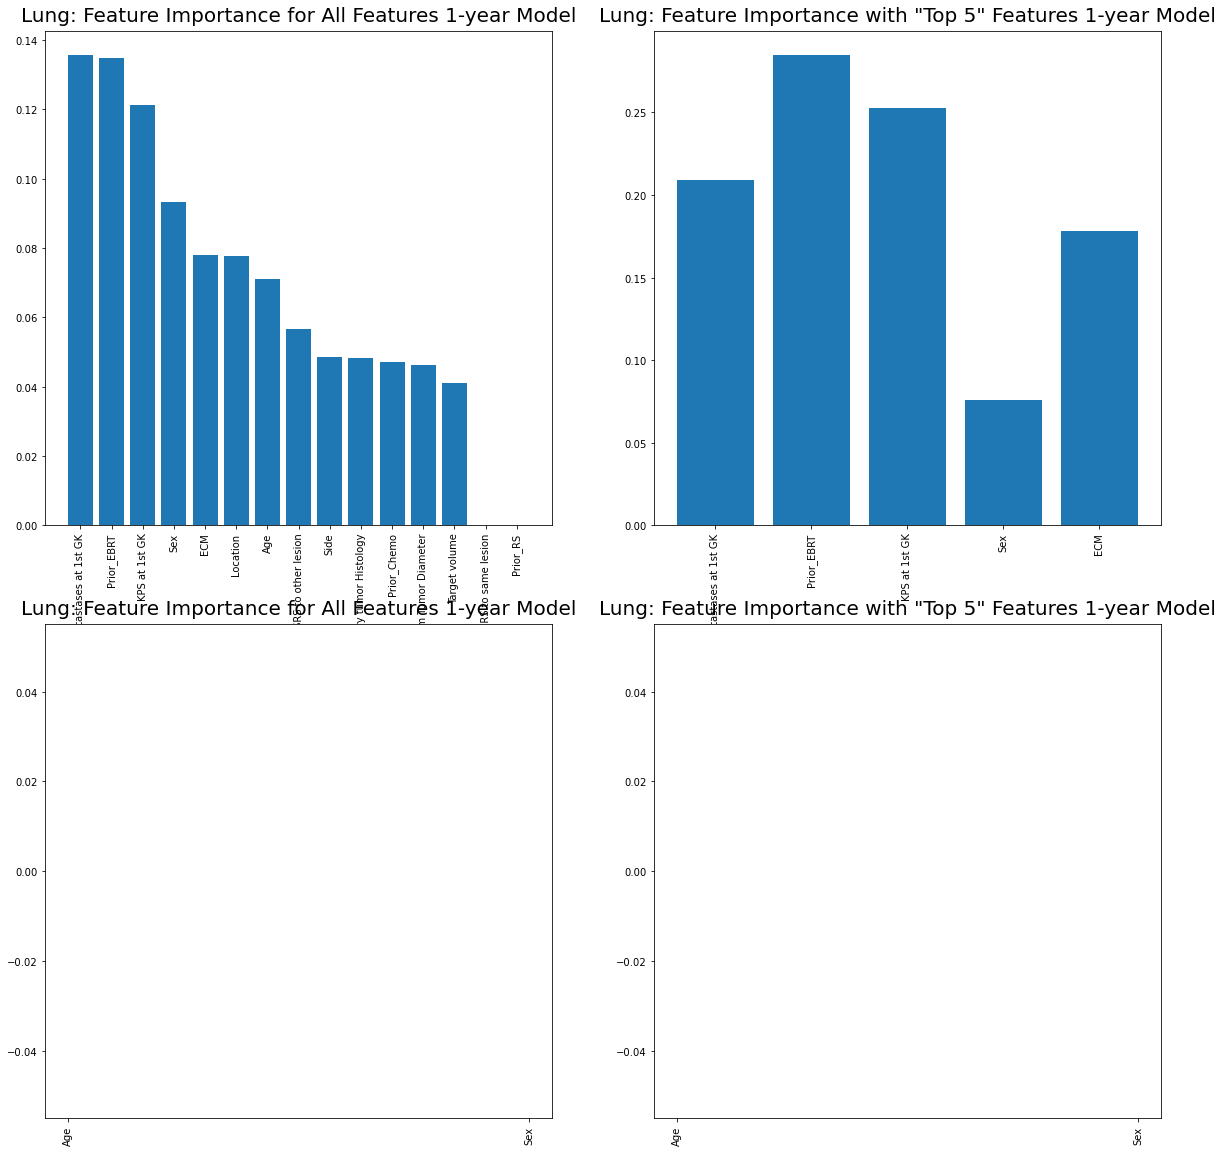

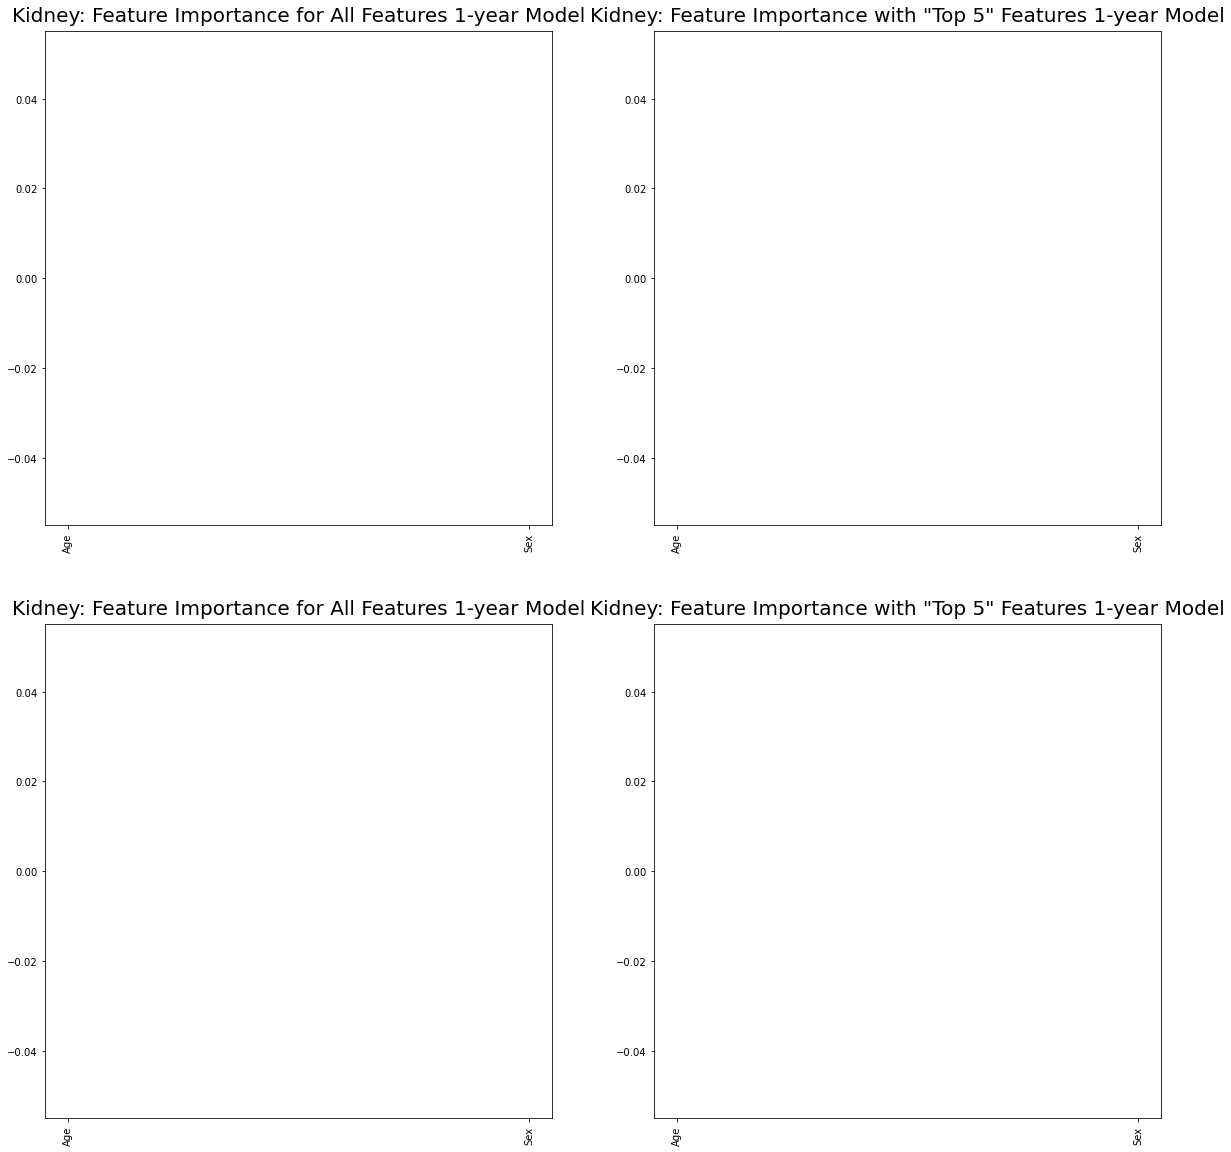

In [28]:
for site,output1,output2 in info:
    m_random1,(m_all1, (acc_all1, roc_all1)),(m_1top5,(acc_1top5,roc_1top5)),shape,features1 = output1
    m_random2,(m_all2, (acc_all2, roc_all2)),(m_2top5,(acc_2top5,roc_2top5)),shape,features2 = output2
    
    print('####',site+':')
    print('X_shape: \t',shape)
    
    data = [['1-year all feature',acc_all1,roc_all1,m_random1.best_params_],
            ['1-year top5 features',acc_1top5,roc_1top5,m_random1.best_params_],
            ['2-year all feature',acc_all2,roc_all2,m_random2.best_params_],
            ['2-year top5 features',acc_2top5,roc_2top5,m_random2.best_params_],]
    
    
    result = pd.DataFrame(data,columns = ['Model','accuracy','roc_auc','parameters'])
    result['accuracy'] = result['accuracy'].apply(lambda x: np.round(x,5))
    result['roc_auc'] = result['roc_auc'].apply(lambda x: np.round(x,5))
    
    print(result)
    print('\n\n')

    fig, axs = plt.subplots(2, 2,figsize = (20,20))

    feature_importance_visual(axs[0,0],features1.keys(),features1.values(),
                              f'{site}: Feature Importance for All Features 1-year Model')
    feature_importance_visual(axs[0,1],list(features1.keys())[:5],m_1top5.feature_importances_,
                              f'{site}: Feature Importance with "Top 5" Features 1-year Model')
    feature_importance_visual(axs[1,0],features2.keys(),features2.values(),
                              f'{site}: Feature Importance for All Features 1-year Model')
    feature_importance_visual(axs[1,1],list(features2.keys())[:5],m_2top5.feature_importances_,
                              f'{site}: Feature Importance with "Top 5" Features 1-year Model')